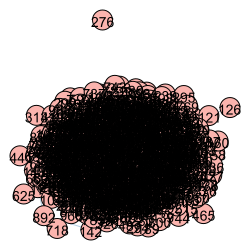

In [20]:
# Load packages
from igraph import *
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
import itertools
from torch.nn.parameter import Parameter


# Create a tree network using igraph method
#G = Graph.Barabasi(n = 1000, m = 3, directed = False)
G = Graph.Erdos_Renyi(n = 1000, p = 0.005, directed = False)


G.vs["name"] = [str(i) for i in range(len(G.vs))]



#transforming to dataframe
g = pd.DataFrame({'source': [x for e in G.es for x in (e.source, e.target)],
                  'target': [x for e in G.es for x in (e.target, e.source)]})
#plotting
p_style = {"bbox": (250, 250), "vertex_color": "#FBB4AE", "edge_color": "#B3CDE3"}
plot(G, layout=G.layout("kk"), vertex_label=G.vs["name"], **p_style)

In [12]:
# Parameters
# Transmission rate
beta = 0.5 
# Recovery rate
gamma = 0.5
#Time 
T = 100
#Initial probability for infected node
p0 = pd.DataFrame({'node': g['source'].unique(), 'prob': 0})
p0.loc[p0['node'].isin([1]), 'prob'] = 0.6

In [21]:
width = 50
def SIR_master_equation(g, p0, beta, gamma, T):
    # Get initial infection probabilities for each node
    nodes, init_probs = p0['node'].tolist(), p0['prob'].tolist()
    
    # Initialize probabilities for each state
    mrg_s = np.zeros((T, len(nodes)))
    mrg_i = np.zeros((T, len(nodes)))
    mrg_r = np.zeros((T, len(nodes)))

    # Set initial state probabilities
    mrg_i[0, :] = np.array(init_probs)
    mrg_s[0, :] = 1.0 - np.array(init_probs)

    # Precompute neighbors
    neighbors = {i: set() for i in nodes}
    for edge in g.itertuples(index=False):
        source, target = edge.source, edge.target
        neighbors[source].add(target)
        neighbors[target].add(source)

    # Master Equation Simulation
    for t in range(1, T):
        for i, node in enumerate(nodes):
            # Calculate the product term for the S and I updates
            product_term = np.prod([1 - beta * mrg_i[t - 1, nodes.index(neighbor)] for neighbor in neighbors[node]])

            # Update Susceptible (S)
            mrg_s[t, i] = mrg_s[t - 1, i] * product_term

            # Update Infected (I)
            mrg_i[t, i] = mrg_i[t - 1, i] + (1 - product_term) * mrg_s[t - 1, i] - gamma * mrg_i[t - 1, i]

            # Update Recovered (R)
            mrg_r[t, i] = mrg_r[t - 1, i] + gamma * mrg_i[t - 1, i]

        # Normalize the probabilities to sum to 1
        for i in range(len(nodes)):
            total = mrg_s[t, i] + mrg_i[t, i] + mrg_r[t, i]
            mrg_s[t, i] /= total
            mrg_i[t, i] /= total
            mrg_r[t, i] /= total
                        

    return mrg_s, mrg_i, mrg_r, len(nodes)

class NN(nn.Module):
    def __init__(self, width=width):
        super(NN, self).__init__()
        self.width = width
        self.one_to_width = nn.Linear(1, self.width)
        self.adaptive_activation = Parameter(torch.ones(self.width))
        self.width_to_one = nn.Linear(self.width, 1)

    def forward(self, t, max):
        output = self.one_to_width(t)
        output = self.adaptive_activation * output
        output = torch.tanh(output)
        output = self.width_to_one(output)
        # Sigmoid to scale between 0 and 1
        output = torch.sigmoid(output) 
        # Scaling up to the maximum value
        output = output * max  
        return output
    
def train_and_compare_models(g, p0, beta, gamma, T, test_split=0.2):
    S, I, R, N = SIR_master_equation(g, p0, beta, gamma, T)

    # Split data into training and testing sets
    idx = np.arange(T)
    np.random.shuffle(idx)
    split = int(T * (1 - test_split))
    train_idx, test_idx = idx[:split], idx[split:]

    # Prepare training and testing data
    S_train, S_test = S[train_idx], S[test_idx]
    I_train, I_test = I[train_idx], I[test_idx]
    R_train, R_test = R[train_idx], R[test_idx]

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    S_nn = NN().to(device)
    I_nn = NN().to(device)
    optimizer = torch.optim.Adam(itertools.chain(S_nn.parameters(), I_nn.parameters()), lr=1e-3)
    MSE = nn.MSELoss()

    S_tensor_train = torch.tensor(S_train, dtype=torch.float).to(device)
    I_tensor_train = torch.tensor(I_train, dtype=torch.float).to(device)

    S_tensor_test = torch.tensor(S_test, dtype=torch.float).to(device)
    I_tensor_test = torch.tensor(I_test, dtype=torch.float).to(device)

    loss_history_train = []
    loss_history_test = []

    for epoch in tqdm(range(500)):
        optimizer.zero_grad()

        # Training
        t_tensor_train = torch.tensor(train_idx, dtype=torch.float).view(-1, 1).to(device)
        prediction_S_train = S_nn(t_tensor_train, N)
        prediction_I_train = I_nn(t_tensor_train, N - prediction_S_train)

        loss_S_train = MSE(prediction_S_train, S_tensor_train[:, 0].view(-1, 1))
        loss_I_train = MSE(prediction_I_train, I_tensor_train[:, 0].view(-1, 1))

        loss_train = loss_S_train + loss_I_train
        loss_train.backward()
        optimizer.step()

        loss_history_train.append(loss_train.item())

        # Testing
        t_tensor_test = torch.tensor(test_idx, dtype=torch.float).view(-1, 1).to(device)
        prediction_S_test = S_nn(t_tensor_test, N)
        prediction_I_test = I_nn(t_tensor_test, N - prediction_S_test)

        loss_S_test = MSE(prediction_S_test, S_tensor_test[:, 0].view(-1, 1))
        loss_I_test = MSE(prediction_I_test, I_tensor_test[:, 0].view(-1, 1))

        loss_test = loss_S_test + loss_I_test

        loss_history_test.append(loss_test.item())
        
   # Calculate the mean squared error for testing
    mean_squared_error_test = sum(loss_history_test) / len(loss_history_test)
    print("Mean Squared Error (Testing):", mean_squared_error_test/100)

    # Plot training and testing losses
    plt.figure(figsize=(12, 8))
    plt.plot(loss_history_train, label='Training Loss')
    plt.plot(loss_history_test, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig('C:/Users/abbau/Downloads/PINN100e.pdf', format='pdf',bbox_inches="tight")
    plt.show()




100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 200.68it/s]


Mean Squared Error (Testing): 129.46843771606444


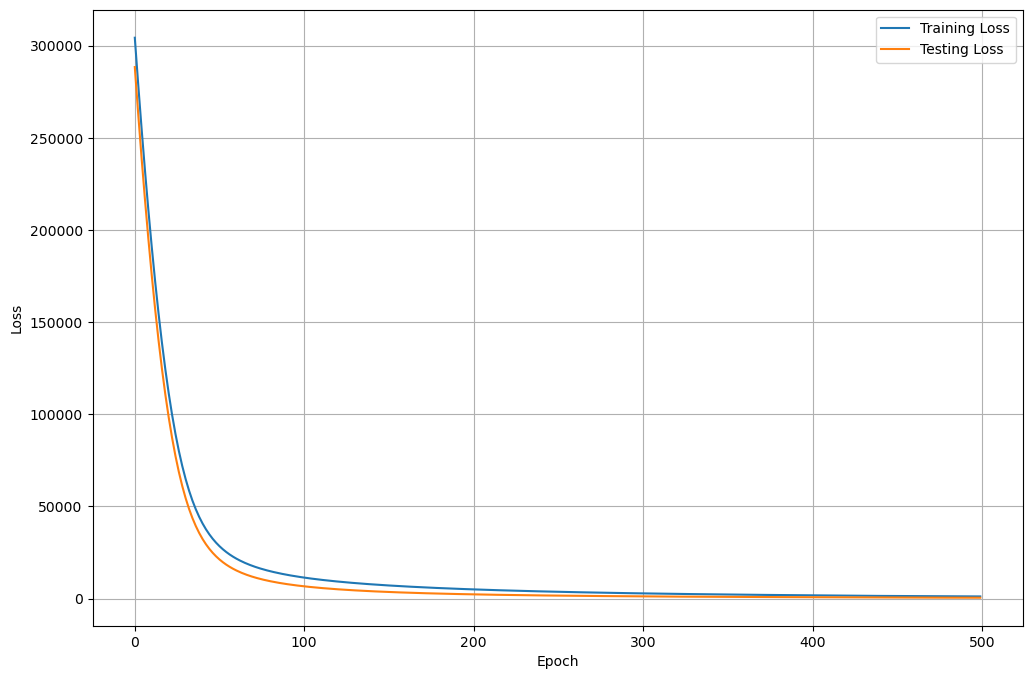

In [22]:
train_and_compare_models(g, p0, beta, gamma, T)

In [23]:
# Training and Comparison Function
def train_and_compare_models(g, p0, beta, gamma, T):
    S, I, R, N = SIR_master_equation(g, p0, beta, gamma, T)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    S_nn = NN().to(device)
    I_nn = NN().to(device)
    optimizer = torch.optim.Adam(itertools.chain(S_nn.parameters(), I_nn.parameters()), lr=1e-3)
    MSE = nn.MSELoss()
    
    S_tensor = torch.tensor(S, dtype=torch.float).to(device)
    I_tensor = torch.tensor(I, dtype=torch.float).to(device)
    R_tensor = torch.tensor(R, dtype=torch.float).to(device)

    loss_history = []

    for epoch in tqdm(range(500)):
        optimizer.zero_grad()

        t_tensor = torch.linspace(0, T-1, steps=T).view(-1, 1).to(device)
        prediction_S = S_nn(t_tensor, N)
        prediction_I = I_nn(t_tensor, N - prediction_S)

        # Calculate losses
        loss_S = MSE(prediction_S, S_tensor[:, 0].view(-1, 1))
        loss_I = MSE(prediction_I, I_tensor[:, 0].view(-1, 1))

        loss = loss_S + loss_I
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

    # Evaluate the model
    S_nn.eval()
    I_nn.eval()
    t_tensor = torch.linspace(0, T-1, steps=T).view(-1, 1).to(device)
    S_list = S_nn(t_tensor, max=N).cpu().detach().numpy()
    I_list = I_nn(t_tensor, max=N).cpu().detach().numpy()
    R_list = N - S_list - I_list
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(S_list/100, label='Susceptible', marker='o')
    plt.plot(I_list/100, label='Infected', marker='o')
    plt.plot(R_list/100, label='Recovered', marker='o')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.savefig('C:/Users/abbau/Downloads/PINN100mae.pdf', format='pdf',bbox_inches="tight")


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 276.52it/s]


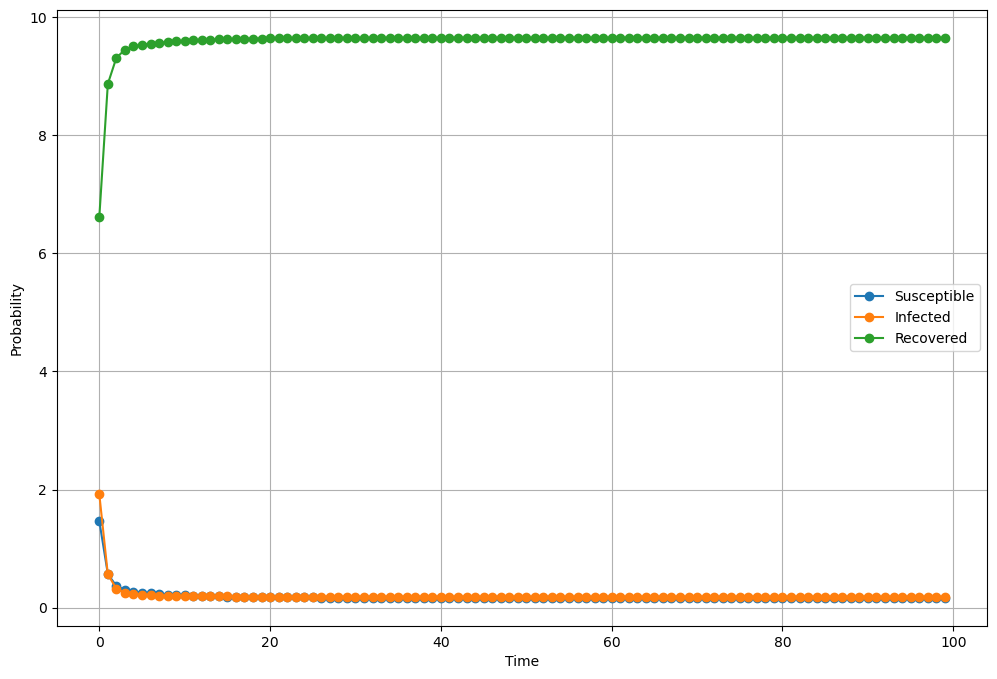

In [24]:
train_and_compare_models(g, p0, beta, gamma, T)